# First Iteration with Recurrent Neural Networks and Post Padding

In [1]:
import pandas as pd
import numpy as np
from progress.bar import Bar
#from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical, pad_sequences

2023-10-24 22:21:39.841966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 22:21:40.561523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 22:21:40.565869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 22:21:44.491971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("./Metadata/data_curated.csv")
df.set_index("File", inplace=True)
df.head()

,Class
File,
S1V3C1M3A Clip166.npy,1
S1V1C1M1A Clip18.npy,1
S1V4C1M4A Clip241.npy,1
S1V4C1M4A Clip239.npy,1
S1V4C1M4A Clip245.npy,1


In [3]:
X_list = []
y_list = []
with Bar("Processing...", max = df.size) as bar:
    for file_name, class_name in df.iterrows():
        np_element = np.load(f"../Clean_Data/{class_name.iloc[0]}/{file_name}")[:33,:]
        X_list.append(np_element)#[:33,:])
        y_list.append(class_name.iloc[0])
        bar.next()

In [4]:
min_arr = 1000
for arr in X_list:
    aux_arr = arr.shape[0]
    if aux_arr < min_arr:
        min_arr = aux_arr
print(min_arr)

33


In [5]:
max_arr = 0
for arr in X_list:
    aux_arr = arr.shape[0]
    if aux_arr > max_arr:
        max_arr = aux_arr
print(max_arr)

33


In [6]:
pad_sequences(X_list[0].T, maxlen=97, padding='post').shape

(1662, 97)

In [7]:
X_list[0].shape

(33, 1662)

In [8]:
X = np.stack(X_list)
y = np.array(y_list)

In [9]:
X.shape

(1500, 33, 1662)

In [10]:
y.shape

(1500,)

# GaussianHMM

# Recurrent Neural Networks

In [11]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(33,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [12]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [13]:
y = to_categorical(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
y_test.shape

(450, 6)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 33, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 33, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 596774 (2.28 MB)
Trainable params: 596774 

In [17]:
model.fit(X_train, y_train, epochs=200, batch_size=128)

Epoch 1/200
9/9 [==============================] - 10s 317ms/step - loss: 19.3951 - categorical_accuracy: 0.2105
Epoch 2/200
9/9 [==============================] - 3s 324ms/step - loss: 5.0083 - categorical_accuracy: 0.2295
Epoch 3/200
9/9 [==============================] - 3s 329ms/step - loss: 2.3594 - categorical_accuracy: 0.1876
Epoch 4/200
9/9 [==============================] - 3s 327ms/step - loss: 1.7882 - categorical_accuracy: 0.1981
Epoch 5/200
9/9 [==============================] - 3s 337ms/step - loss: 1.7265 - categorical_accuracy: 0.2019
Epoch 6/200
9/9 [==============================] - 3s 329ms/step - loss: 1.6415 - categorical_accuracy: 0.2105
Epoch 7/200
9/9 [==============================] - 3s 327ms/step - loss: 1.6638 - categorical_accuracy: 0.2219
Epoch 8/200
9/9 [==============================] - 3s 314ms/step - loss: 1.5958 - categorical_accuracy: 0.2619
Epoch 9/200
9/9 [==============================] - 3s 313ms/step - loss: 1.6097 - categorical_accuracy: 0.2686

In [18]:
y_pred = model.predict(X_test)

15/15 [==============================] - 2s 68ms/step


In [19]:
y_pred = np.argmax(y_pred, axis=1).tolist()

In [20]:
y_true = np.argmax(y_test, axis=1).tolist()

In [21]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay, confusion_matrix

In [22]:
confusion_matrices = confusion_matrix(y_true, y_pred,labels=np.unique(y_pred), normalize='true')

In [23]:
confusion_matrices

array([[0.79207921, 0.        , 0.08910891, 0.        , 0.11881188],
       [0.        , 0.92391304, 0.        , 0.02173913, 0.05434783],
       [0.12765957, 0.        , 0.85106383, 0.0106383 , 0.0106383 ],
       [0.        , 0.        , 0.        , 0.82352941, 0.17647059],
       [0.05128205, 0.01282051, 0.23076923, 0.15384615, 0.55128205]])

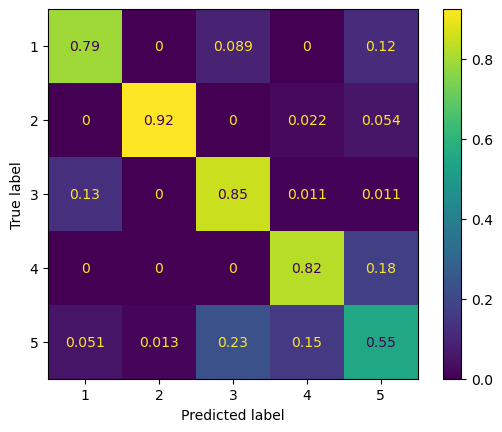

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrices, display_labels=np.unique(y_pred))
disp.plot()